# Pipeline processing using Dask

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
%matplotlib inline

import os
import sys

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from dask import delayed
import dask.bag as bag

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.image.gather_scatter import image_gather
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.imaging import predict_2d, create_image_from_visibility, advise_wide_field
from arl.graphs.dask_init import get_dask_Client
from arl.graphs.graphs import create_invert_wstack_graph, create_deconvolve_facet_graph, \
    create_residual_wstack_graph

from arl.graphs.generic_graphs import create_generic_image_graph
from arl.util.graph_support import create_simulate_vis_graph, \
    create_predict_gleam_model_graph
from arl.pipelines.graphs import create_continuum_imaging_pipeline_graph, \
    create_ical_pipeline_graph    
from arl.graphs.vis import simple_vis

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Make a Dask client to manage the processing. Diagnostics are available at the URL given. Try the Status entry.

In [2]:
c=get_dask_Client()

Creating Dask Client
<Client: scheduler='tcp://127.0.0.1:49962' processes=8 cores=8>
Diagnostic pages available on port http://127.0.0.1:8787


We create a graph to make the visibility 

In [3]:
nfreqwin=7
ntimes=11
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

vis_graph_list=create_simulate_vis_graph('LOWBD2-CORE',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre)

Now make a graph to fill with a model drawn from GLEAM 

In [4]:
wprojection_planes=1
advice=advise_wide_field(vis_graph_list[0].compute(), guard_band_image=4.0, delA=0.02,
                         wprojection_planes=wprojection_planes)
vis_slices = advice['vis_slices']

advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Maximum baseline 210.1 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)
advise_wide_field: Synthesized beam 0.004759 (rad) 0.273 (deg)
advise_wide_field: Cellsize 0.001586 (rad) 0.091 (deg)
advice_wide_field: Npixels per side = 270
advice_wide_field: W sampling for full image = 0.3 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 45.4 (s)
advice_wide_field: Time sampling for primary beam = 726.9 (s)
advice_wide_field: Frequency sampling for full image = 42066.2 (Hz)
advice_wide_field: Frequency sampling for primary beam = 673058.5 (Hz)
advice_wide_field: Number of planes in w stack 37
advice_wide_field: Number of planes in w projection 1
advice_wide_field: Recommend 2d gridding


In [5]:
def compute_list(c, vis_graph_list: delayed):
    """ Compute all elements in list
    
    :param vis_graph_list:
    :return: list
    """
    future = c.compute(vis_graph_list)
    return [f.result() for f in future]

In [6]:
predicted_vis_graph_list = create_predict_gleam_model_graph(vis_graph_list, 
                                                            vis_slices=advice['vis_slices'])

predicted_vis_graph_list = compute_list(c, predicted_vis_graph_list)

Compute the data sets so the work does not show up in our subsequent graphs

In [7]:
corrupted_vis_graph_list = create_predict_gleam_model_graph(vis_graph_list, 
                                                            vis_slices=advice['vis_slices'],
                                                            phase_error=1.0)
corrupted_vis_graph_list=compute_list(c, corrupted_vis_graph_list)

Get the LSM. This is currently blank.

In [8]:
def get_LSM(vt, npixel = 512, cellsize=0.001, reffrequency=[1e8]):
    model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, 
                                         npol=1, frequency=reffrequency,
                                         polarisation_frame=PolarisationFrame("stokesI"))
    return model

model_graph=delayed(get_LSM)(vis_graph_list[len(vis_graph_list)//2])

Create a graph to make the dirty image 

In [9]:
dirty_graph = create_invert_wstack_graph(predicted_vis_graph_list, model_graph, 
                                         vis_slices=advice['vis_slices'], dopsf=False)

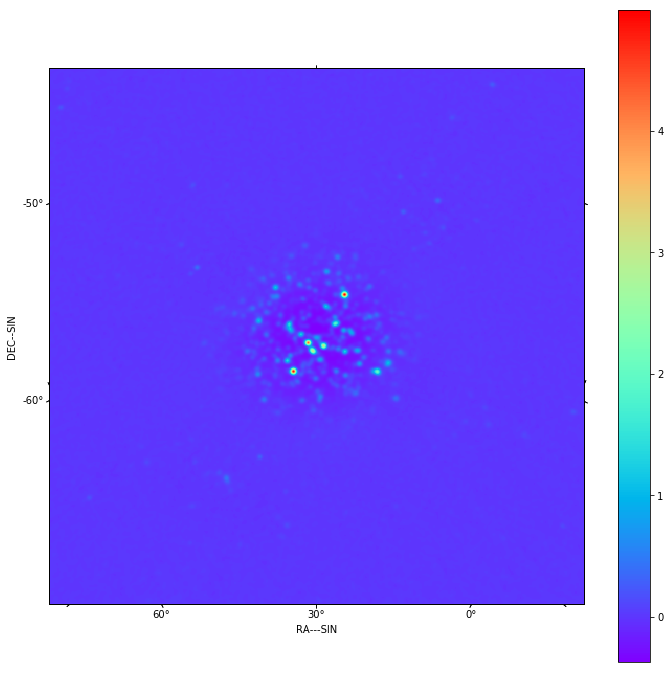

In [10]:
dirty=dirty_graph.compute()
show_image(dirty[0])
plt.show()

In [11]:
continuum_imaging_graph = \
    create_continuum_imaging_pipeline_graph(predicted_vis_graph_list, 
                                            model_graph=model_graph, 
                                            c_deconvolve_graph=create_deconvolve_facet_graph,
                                            facets=1,
                                            c_invert_graph=create_invert_wstack_graph,
                                            c_residual_graph=create_residual_wstack_graph,
                                            vis_slices=advice['vis_slices'], 
                                            algorithm='hogbom', niter=1000, 
                                            fractional_threshold=0.1,
                                            threshold=0.1, nmajor=5, gain=0.1)

In [12]:
future=c.compute(continuum_imaging_graph)

Quality assessment:
	Origin: qa_image
	Context: Clean image - no selfcal
	Data:
		shape: (1, 1, 512, 512)
		max: 4.58024909784
		min: -0.0367982383244
		rms: 0.0188890004986
		sum: 79.0430395524
		medianabs: 0.0
		median: 0.0



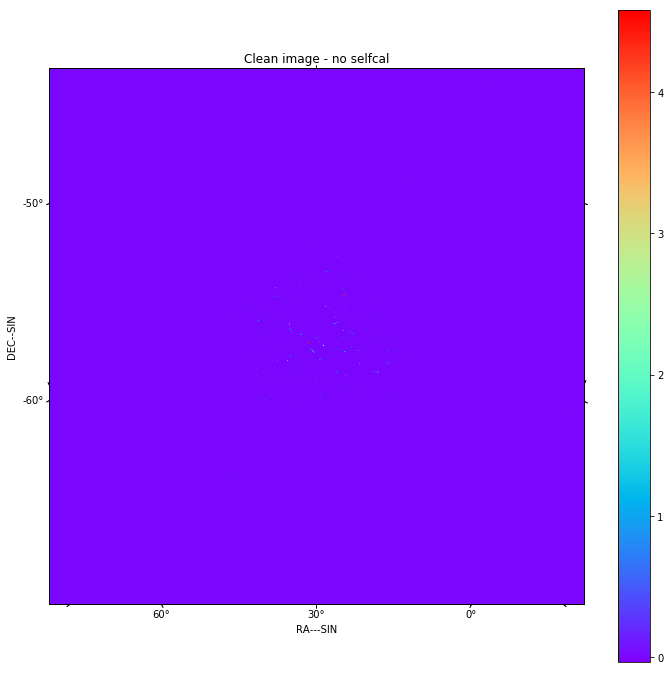

Quality assessment:
	Origin: qa_image
	Context: Restored clean image - no selfcal
	Data:
		shape: (1, 1, 512, 512)
		max: 5.0786584308
		min: -0.166366215558
		rms: 0.0873469684135
		sum: 1929.97935904
		medianabs: 0.00347417333704
		median: -0.000696892969275



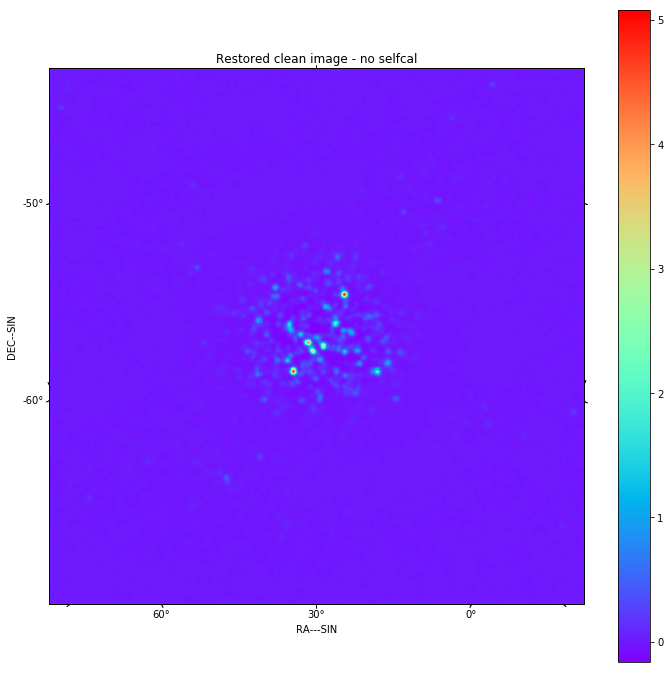

Quality assessment:
	Origin: qa_image
	Context: Residual clean image - no selfcal
	Data:
		shape: (1, 1, 512, 512)
		max: 0.0999116239031
		min: -0.0996254122089
		rms: 0.0162476603048
		sum: 25.9253858837
		medianabs: 0.00346348697252
		median: -0.000787488407181



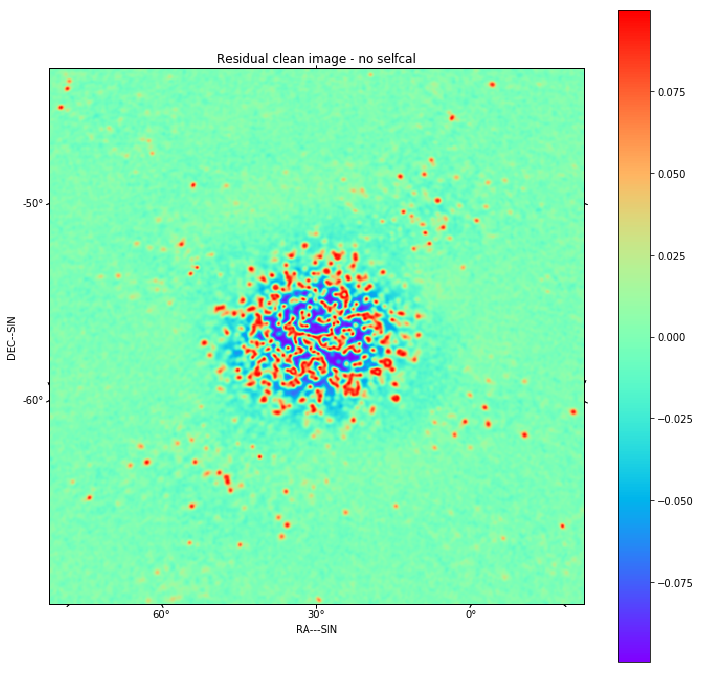

In [13]:
deconvolved = future.result()[0]
residual = future.result()[1]
restored = future.result()[2]

f=show_image(deconvolved, title='Clean image - no selfcal')
print(qa_image(deconvolved, context='Clean image - no selfcal'))

plt.show()

f=show_image(restored, title='Restored clean image - no selfcal')
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_continuum_imaging_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image - no selfcal')
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_continuum_imaging_residual.fits' 
                     %(results_dir))

In [14]:
ical_graph = create_ical_pipeline_graph(corrupted_vis_graph_list, 
                                        model_graph=model_graph,  
                                        c_deconvolve_graph=create_deconvolve_facet_graph,
                                        c_invert_graph=create_invert_wstack_graph,
                                        c_residual_graph=create_residual_wstack_graph,
                                        vis_slices=vis_slices, 
                                        algorithm='hogbom', niter=1000, 
                                        fractional_threshold=0.1,
                                        threshold=0.1, nmajor=5, 
                                        gain=0.1, first_selfcal=1)

Quality assessment:
	Origin: qa_image
	Context: Clean image
	Data:
		shape: (1, 1, 512, 512)
		max: 4.58024909784
		min: -0.0367485780654
		rms: 0.0188901808036
		sum: 79.1204400749
		medianabs: 0.0
		median: 0.0



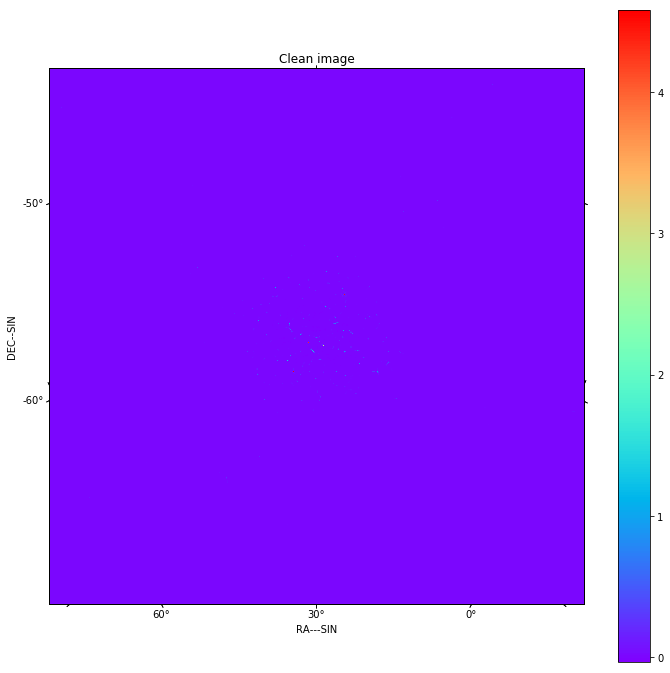

Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: (1, 1, 512, 512)
		max: 5.07890217851
		min: -0.16635117475
		rms: 0.0873538355381
		sum: 1931.87750037
		medianabs: 0.00346949206604
		median: -0.00069735847753



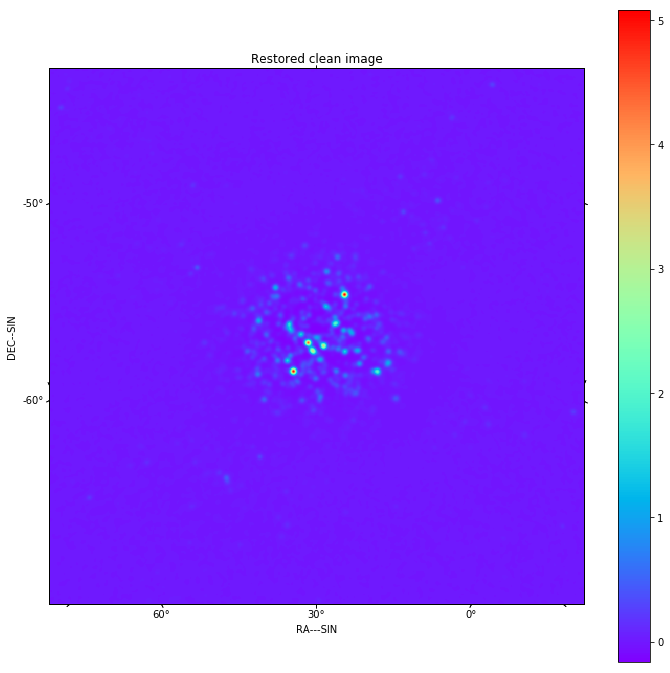

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: (1, 1, 512, 512)
		max: 0.0999119762612
		min: -0.0997139343189
		rms: 0.0162077233865
		sum: 25.9590395445
		medianabs: 0.00345828461376
		median: -0.000791020626576



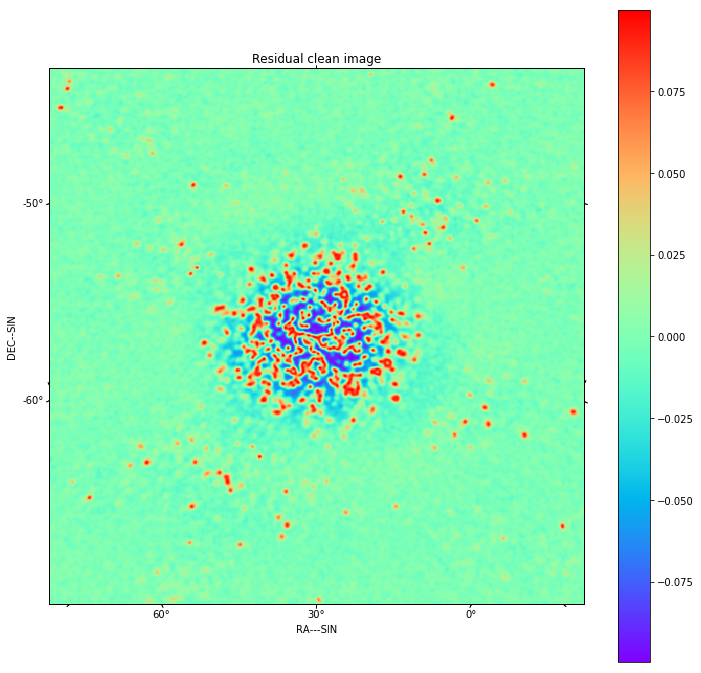

In [15]:
future=c.compute(ical_graph)
deconvolved = future.result()[0]
residual = future.result()[1]
restored = future.result()[2]

f=show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f=show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_ical_restored.fits' 
                     %(results_dir))



f=show_image(residual[0], title='Residual clean image')
print(qa_image(residual[0], context='Residual clean image'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_ical_residual.fits' 
                     %(results_dir))

In [16]:
c.shutdown()

distributed.batched - INFO - Batched Comm Closed: Stream is closed
distributed.batched - INFO - Batched Comm Closed: Stream is closed
distributed.nanny - CRITICAL - Unable to unregister with scheduler None. Nanny: tcp://127.0.0.1:49964, Worker: tcp://127.0.0.1:49973
distributed.nanny - CRITICAL - Unable to unregister with scheduler None. Nanny: tcp://127.0.0.1:49966, Worker: tcp://127.0.0.1:49980
distributed.nanny - CRITICAL - Unable to unregister with scheduler None. Nanny: tcp://127.0.0.1:49965, Worker: tcp://127.0.0.1:49982
distributed.nanny - CRITICAL - Unable to unregister with scheduler None. Nanny: tcp://127.0.0.1:49970, Worker: tcp://127.0.0.1:49992
distributed.nanny - CRITICAL - Unable to unregister with scheduler None. Nanny: tcp://127.0.0.1:49963, Worker: tcp://127.0.0.1:49972
distributed.nanny - CRITICAL - Unable to unregister with scheduler None. Nanny: tcp://127.0.0.1:49967, Worker: tcp://127.0.0.1:49989
tornado.application - ERROR - Exception in callback functools.partia